In [106]:
import matplotlib.pyplot as plt
from config import settings

import pymongo
%matplotlib inline

plt.style.use('ggplot')
plt.rcParams['font.size'] = 25

# db = pymongo.MongoClient("mongodb://localhost:27017/")['Jan16_cloudseg_saliency_loss']
db = pymongo.MongoClient("mongodb://localhost:27017/")['Jan30_encoding_preset']

In [107]:
approach1 = 'backprop_sigmoid_saliency_error_add_preset_lr_0.1'
approach2 = 'chameleon'

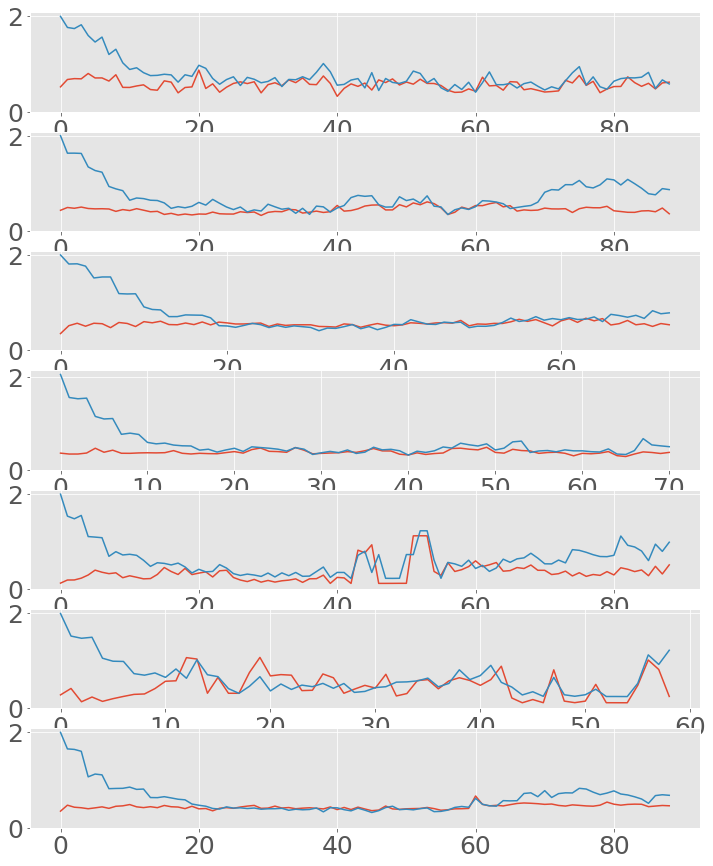

In [109]:


import numpy as np
fmts = [f'videos/yoda/dashcam_{i}/part%d.mp4' for i in [1,2,3,4,5,6,7,8]]
def query_approach(ax, approach, label, fmt, column='stats'):
    f1s = []

    try:

        for sec in range(0, 1000):

            query = {
                'second': sec,
                'command_line_args.approach': approach,
                'command_line_args.input': fmt,
            }

            x = list(db['stats'].find(query))
            x = sorted(x, key = lambda x: x['_id'])
            f1s.append(x[-1])

    except IndexError:
        pass



    ax.plot(range(len(f1s)), [1 - i['f1'] \
        + settings.backprop.bw_weight * i['norm_bw'] \
            + settings.backprop.compute_weight * len(i['encoded_frames'])/10 for i in f1s], label=label)
    
    # ax[1].plot(range(len(f1s)), [i['f1'] for i in f1s], label=label)
    

fig, axs = plt.subplots(7, figsize=(12, 15))
j = 0
for i in range(8):
    if i == 2:
        continue
    query_approach(axs[j], approach2, 'Baseline', fmts[i])
    query_approach(axs[j], approach1, 'Ours', fmts[i])
    axs[j].set_ylim(bottom=0)
    # axs[j].legend()
    j += 1
# query_approach(ax, approach3, 'Cheat')

ax.legend()

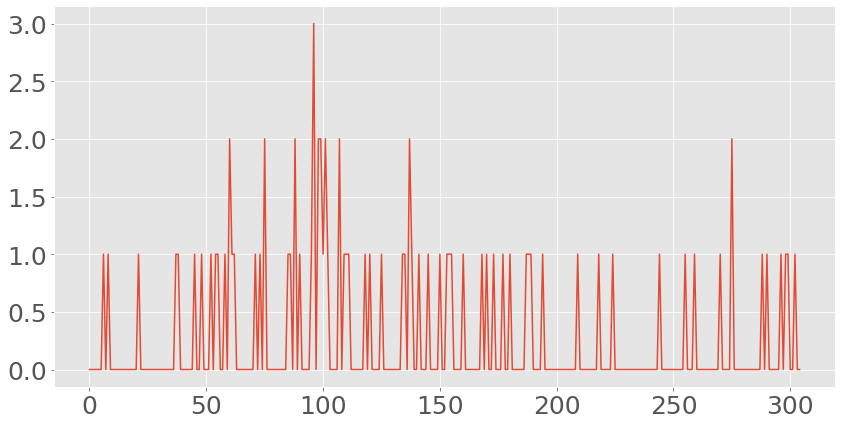

In [36]:
fig, ax = plt.subplots(figsize=(14, 7))
hidden_fns = list(db['Hidden_FP'].find())
hidden_fns = [i['count'] for i in hidden_fns]
ax.plot(hidden_fns)